# Tecnológico de Costa Rica

## Curso Procesamiento de Lenguaje Natural

### Profesores: Maria Auxiliadora Mora Cross y José Enrique Araya Monge

#### Estudiante: José Alberto Raygada Agüero

Tarea No. 2

_____

La tarea consiste en usar los algoritmos de clasificación de texto vistos en clase, para clasificar los comentarios hechos sobre los hoteles en la región de Andalucía en España. La colección está en español. Se usará un subconjunto de la colección original, debido a que los hoteles andaluces son muy buenos en general y las clases quedan muy desbalanceadas. 

El archivo de datos tiene el formato csv. Algunos registros (796) tienen un pequeño error. En esos registros, un campo delimitado por doble comillas (“campo”), tiene la segunda comilla en la siguiente línea (“campo\n”), lo cual causa que algunas herramientas corten el registro allí y uno tomen en cuenta los campos adicionales que hay esa siguiente línea. Se deja como opcional ajustar la herramienta (no los datos) para cargarlo correctamente, o como se les pide, ignorar los registros que tengan valores omitidos.


In [115]:
# Librerías a utilizar
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection
import sklearn.preprocessing as preproc
from sklearn.feature_extraction import text
import pickle
import warnings
warnings.filterwarnings("ignore")

Escribir un cuaderno de Jupyter que realice las siguientes acciones. Puede basarse en el cuaderno Sesión 3 – Clasificación de Texto. Puede bajar la colección y el archivo de stopwords y que el cuaderno los acceda desde el sistema de archivo. Sin embargo, asegúrese de que el cuaderno los accede  usando un path que no dependa de su máquina.

#### Carga (20 ptos.)

##### 1.	Cargar el archivo 'Balanced_AHR.csv' bajarlo de Internet.

In [47]:
# Se supondrá que los archivos auxiliares estarán disponibles
# en el mismo directorio de este cuaderno.
import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./Balanced_AHR.csv
./Tarea 02 - José Alberto Raygada v2.ipynb
./Tarea 02 - José Alberto Raygada.ipynb
./.ipynb_checkpoints\Tarea 02 - José Alberto Raygada v2-checkpoint.ipynb
./.ipynb_checkpoints\Tarea 02 - José Alberto Raygada-checkpoint.ipynb


In [48]:
balanced = pd.read_csv('Balanced_AHR.csv', index_col=0)
balanced.head()

,title,rating,review_text,location,hotel,label
0,IMPOSIBLE DESCANSAR,2,"El fin de semana mi pareja y yo hicimos una reserva en este hotel, con el fin de descansar y desconectar, fue sólo una noche y menos mal. Nos llevaron a un ala bastante apartada del hotel porque nos dijeron que era mejor para descansar ya que la parte de fuera era muy “jaleosa”. Nos pareció bien porque era justo lo que buscábamos, y cuál fue nuestra sorpresa? Desde las 6 de la mañana con ruidos, primero lo que suponemos que eran unos tacones en la habitación de arriba (de eso no tiene culpa...",Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,0
1,No es oro todo lo que reluce,3,"El hotel en general está bien, las habtiaciones son espaciosas y el personal es muy amable (sobretodo el encargado del roof-top y la piscina) y la zona de la piscina es curiosa. Pero tiene dos grandes fallos: El primero es que el wifi no llegaba bien a la habitación ya que se cortaba continuamente. El segundo fallo es que no se les ocurre otra cosa que poner un edredón nórdico en vez de una sábana fina en pleno agosto en Sevilla.",Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,3
2,Un buen hotel con mucho ruido.,3,"El hotel es moderno, amplio y limpio, pero no hemos podido disfrutar de la experiencia porque con tanto ruido no hemos podido descansar. Además la piscina estaba llena de gente y no la hemos podido usar. Los empleados muy amables y la ubicación perfecta.",Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,3
3,SIN CALEFACCIÓN OPERATIVA Y CON FRÍO,2,Calefacción averiada o no operativa. Se comenta en recepción y no me hacen caso. reitero y tampoco ni caso. Pasé frío. No es admisible en ningún hotel pero menos en un hotel de esta supuesta categoría,Seville_Province_of_Seville_Andalucia,Melia_Sevilla,0
4,Deja bastante que desear.,2,Este hotel ha bajado notoriamente su categoria. Sus habitaciones son bastante hostiles y el Room service es pesimo. No ponen amenities en el baño y las toallas son viejas. La ducha no tiene presion. Deberian de preocuparse un poco mas por dar mejor servicio,Seville_Province_of_Seville_Andalucia,Melia_Sevilla,0


In [49]:
balanced["rating"].describe()

count    7615.000000
mean        3.130269
std         1.548310
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

##### 2.	Hay 796 registros que tienen un error de formato que provoca valores perdidos. Eliminarlos.

In [50]:
# Se utiliza una copia del dataframe para indentificar los valores nulos

df = balanced
df.isnull()
df.isnull().sum()

title            0
rating           0
review_text      0
location       796
hotel          796
label            0
dtype: int64

In [51]:
# Efectivamente existen 796 registros con valores nulos (en las columnas de 'location' y de 'hotel')
# los cuales se procede a eliminar

balanced = balanced.dropna()

df = balanced
df.isnull()
df.isnull().sum()

title          0
rating         0
review_text    0
location       0
hotel          0
label          0
dtype: int64

##### 3.	Contar la frecuencia de las clases, columna 'label' y mostrarla en un gráfico. Calcular el porcentaje de cada clase.

In [52]:
# Cálculo de la frecuencia de las clases, columna 'label' 

dfreq = (balanced
                .groupby('label')
                .agg(frequency=("label", "count")))

dfreq

,frequency
label,
0,2160
1,2670
3,1989


<IPython.core.display.Javascript object>


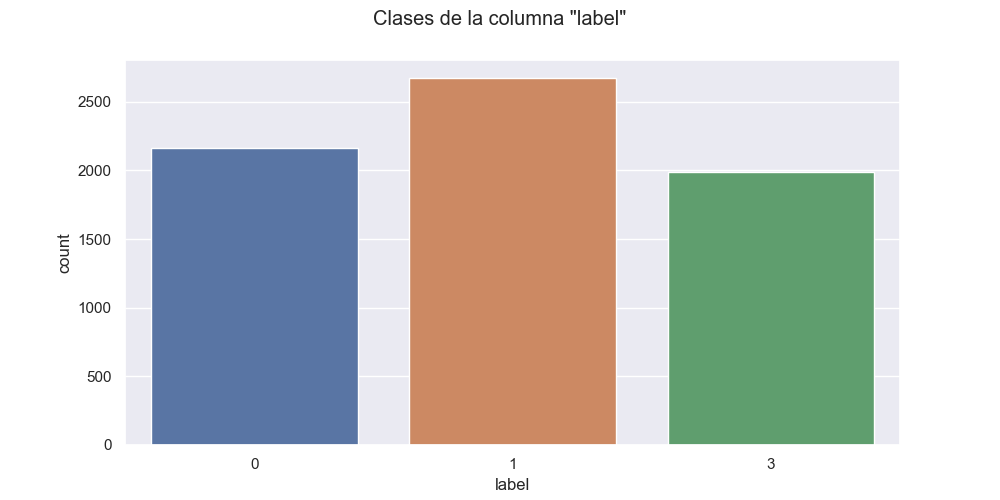

In [64]:
# Se muestran las frecuencias de las diferentes clases en un gráfico

sns.set_theme(style="darkgrid")
fig, (ax1) = plt.subplots(1, figsize=(10, 5), sharey=True)
fig.suptitle('Clases de la columna "label"')
sns.countplot(data=balanced, x=balanced.label, ax=ax1)
plt.show()

In [54]:
# Calculo del porcentaje de cada clase

dfreq['Percentage'] = dfreq['frequency'] / dfreq['frequency'].sum()
dfreq.style.format({'Percentage': '{:,.2%}'.format,})

,frequency,Percentage
label,,
0,2160,31.68%
1,2670,39.16%
3,1989,29.17%


##### 4.	Obtener la lista de stopwords para español. 

In [55]:
stopwspn = nltk.corpus.stopwords.words('spanish')
print(len(stopwspn))
stopwspn

313


['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

#### Pre-procesamiento (35 ptos.)

##### 5.	Limpiar el texto del campo review_text, crear nuevo campo llamado Texto_limpio. Debe dejarlo una lista con las palabras tokenizadas. Debe convertir a minúsculas y eliminar caracteres especiales, en particular '¿' y '¡'. (15 ptos.)


In [56]:
def limpiar_texto(text, quitar_stopwords = True):
    
    """
    Función para eliminar los carácteres no deseados (especiales como '¿'y'¡') de la columna indicada 
    convirtiendo a minúsculas, dejándolo en una columna nueva llamda "Texto_limpio", y  dejando una 
    lista de palabras tokenizadas.
    """
       
    # Convertir el texto a minúsculas
    text = text.lower()
       
    # Formatea el texto y elimina caracteres no deseados
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!¡¿?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'y', '', text)
    
    # Elimina las stop words
    if quitar_stopwords:
        text = text.split()
        stops = set(stopwords.words("spanish"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
    
    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)
        
    return text

In [57]:
# limpiar el texto de la columna review_text y crear nueva columna: Texto_limpio
df = balanced
#df
df["Texto_limpio"] = list(map(limpiar_texto, df['review_text']))
df

,title,rating,review_text,location,hotel,label,Texto_limpio
0,IMPOSIBLE DESCANSAR,2,"El fin de semana mi pareja y yo hicimos una reserva en este hotel, con el fin de descansar y desconectar, fue sólo una noche y menos mal. Nos llevaron a un ala bastante apartada del hotel porque nos dijeron que era mejor para descansar ya que la parte de fuera era muy “jaleosa”. Nos pareció bien porque era justo lo que buscábamos, y cuál fue nuestra sorpresa? Desde las 6 de la mañana con ruidos, primero lo que suponemos que eran unos tacones en la habitación de arriba (de eso no tiene culpa...",Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,0,"[fin, semana, pareja, hicimos, reserva, hotel, fin, descansar, desconectar, sólo, noche, menos, mal, llevaron, ala, bastante, apartada, hotel, dijeron, mejor, descansar, parte, mu, “, jaleosa, ”, pareció, bien, justo, buscábamos, cuál, sorpresa, 6, mañana, ruidos, primero, suponemos, tacones, habitación, arriba, culpa, hotel, obviamente, después, 7, limpiadoras, moviendo, muebles, arrastrando, sofás, cogido, sólo, alojamiento, descansar, pensando, tener, madrugar, habitualmente, imposible, r..."
1,No es oro todo lo que reluce,3,"El hotel en general está bien, las habtiaciones son espaciosas y el personal es muy amable (sobretodo el encargado del roof-top y la piscina) y la zona de la piscina es curiosa. Pero tiene dos grandes fallos: El primero es que el wifi no llegaba bien a la habitación ya que se cortaba continuamente. El segundo fallo es que no se les ocurre otra cosa que poner un edredón nórdico en vez de una sábana fina en pleno agosto en Sevilla.",Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,3,"[hotel, general, bien, habtiaciones, espaciosas, personal, mu, amable, sobretodo, encargado, roof, top, piscina, zona, piscina, curiosa, dos, grandes, fallos, primero, wifi, llegaba, bien, habitación, cortaba, continuamente, segundo, fallo, ocurre, cosa, poner, edredón, nórdico, vez, sábana, fina, pleno, agosto, sevilla]"
2,Un buen hotel con mucho ruido.,3,"El hotel es moderno, amplio y limpio, pero no hemos podido disfrutar de la experiencia porque con tanto ruido no hemos podido descansar. Además la piscina estaba llena de gente y no la hemos podido usar. Los empleados muy amables y la ubicación perfecta.",Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,3,"[hotel, moderno, amplio, limpio, podido, disfrutar, experiencia, ruido, podido, descansar, además, piscina, llena, gente, podido, usar, empleados, mu, amables, ubicación, perfecta]"
3,SIN CALEFACCIÓN OPERATIVA Y CON FRÍO,2,Calefacción averiada o no operativa. Se comenta en recepción y no me hacen caso. reitero y tampoco ni caso. Pasé frío. No es admisible en ningún hotel pero menos en un hotel de esta supuesta categoría,Seville_Province_of_Seville_Andalucia,Melia_Sevilla,0,"[calefacción, averiada, operativa, comenta, recepción, hacen, caso, reitero, tampoco, caso, pasé, frío, admisible, ningún, hotel, menos, hotel, supuesta, categoría]"
4,Deja bastante que desear.,2,Este hotel ha bajado notoriamente su categoria. Sus habitaciones son bastante hostiles y el Room service es pesimo. No ponen amenities en el baño y las toallas son viejas. La ducha no tiene presion. Deberian de preocuparse un poco mas por dar mejor servicio,Seville_Province_of_Seville_Andalucia,Melia_Sevilla,0,"[hotel, bajado, notoriamente, categoria, habitaciones, bastante, hostiles, room, service, pesimo, ponen, amenities, baño, toallas, viejas, ducha, presion, deberian, preocuparse, mas, dar, mejor, servicio]"
...,...,...,...,...,...,...,...
7610,"Muy buen hotel, recien abierto.",5,"Bastante cerca del centro de sevilla, servicios muy esmerados, camas y estancias de muy buena calidad, amplias. Buen bufet en el desayuno. Empleados muy serviciales, atentos y cordiales. La unica pega, por decir algo, el parquing de momento no tiene acceso directo al hotel.",Seville_Province_of_Seville_Andalucia,Eurostars_Guadalquivir,1,"[bastante, cerca, centro, sevilla, ser

##### 6.	Usar el removedor de sufijos (snowball stemmer) provisto por nltk para español. Aplicárselo al campo Texto_limpio para obtener el campo Texto_simple. (15 ptos.)


In [61]:
# Remover los sufijos con el snowball stemmer de nltk en español

def snowstemmer(text):
    stemer = nltk.stem.SnowballStemmer(language = 'spanish')
    df['Texto_simple'] = list(map(lambda word:
                                 list(map(stemer.stem, word)),
                                 df.Texto_limpio))

snowstemmer(df.Texto_limpio)

In [62]:
# Mostrar las columnas de interés del conjunto de datos.
# La opción max_colwidth permite regular la cantidad de texto que se muestra.
# Se muestran tres registros aleatorios.

pd.set_option('max_colwidth', 500)
df[['rating', 'review_text', 'label', 'Texto_limpio', 'Texto_simple']].sample(3)

,rating,review_text,label,Texto_limpio,Texto_simple
940,2,"Buena ubicación para dirigirte al aeropuerto. El servicio en recepción fue bastante bueno. Ahora las camas estaban mal hechas, sabanas al revés, las fundas de edredones mal colocadas... y el servicio de desayuno deja bastante que desear! Lo reservamos la noche anterior por 8€ cada uno pero cuando llegamos a las 8 de la mañana las máquinas del café no funcionaban, la tostadora tampoco, habían solo dos camareras, tuvimos que esperar para pedir unos huevos revueltos y el resultado ya lo verán e...",0,"[buena, ubicación, dirigirte, aeropuerto, servicio, recepción, bastante, bueno, ahora, camas, mal, hechas, sabanas, revés, fundas, edredones, mal, colocadas, servicio, desauno, deja, bastante, desear, reservamos, noche, anterior, 8, €, cada, llegamos, 8, mañana, máquinas, café, funcionaban, tostadora, tampoco, solo, dos, camareras, esperar, pedir, huevos, revueltos, resultado, verán, foto, si, quieres, descansar, hotel, bastante, bien]","[buen, ubic, dirigirt, aeropuert, servici, recepcion, bastant, buen, ahor, cam, mal, hech, saban, reves, fund, edredon, mal, coloc, servici, desaun, dej, bastant, des, reserv, noch, anterior, 8, €, cad, lleg, 8, mañan, maquin, caf, funcion, tostador, tampoc, sol, dos, camarer, esper, ped, huev, revuelt, result, veran, fot, si, quier, descans, hotel, bastant, bien]"
4084,1,"Lamentables condiciones del piso, las fotos que se muestran en el anuncio son falsas, persianas que no funcionan, ventanas que no cierran bien, se sufren picaduras de insectos, cama de matrimonio en malas condiciones. No lo recomiendo.",0,"[lamentables, condiciones, piso, fotos, muestran, anuncio, falsas, persianas, funcionan, ventanas, cierran, bien, sufren, picaduras, insectos, cama, matrimonio, malas, condiciones, recomiendo]","[lament, condicion, pis, fot, muestr, anunci, fals, persian, funcion, ventan, cierr, bien, sufr, picadur, insect, cam, matrimoni, mal, condicion, recom]"
3898,3,"El hotel es muy normalito, está bien situado. El personal de recepción muy poco preparado y bastantes secos en el trato. El desayuno bastante básico. El aparcamiento se encuentra al otro lado de la plaza y es bastante caro.",3,"[hotel, mu, normalito, bien, situado, personal, recepción, mu, preparado, bastantes, secos, trato, desauno, bastante, básico, aparcamiento, encuentra, lado, plaza, bastante, caro]","[hotel, mu, normalit, bien, situ, personal, recepcion, mu, prepar, bastant, sec, trat, desaun, bastant, basic, aparc, encuentr, lad, plaz, bastant, car]"


##### 7.	Separar la colección en conjunto de entrenamiento y conjunto de prueba. Dar un 75% de los registros al conjunto de entrenamiento. (5 ptos.)


In [121]:
# Separacion de los datos en un conjunto de entrenamiento y un conjunto de prueba.
# Distribución: 75% entrenamiento, 25% prueba.

training_data, test_data = sklearn.model_selection.train_test_split(df, train_size = 0.75, random_state=42)

#### 8. Experimientos (40 ptos.)

##### 9.  Realizar las cuatro clasificaciones que se detallan en la tabla siguiente. Usar bag-of-words como vectorización. Además, imprimir el valor de acierto para cada uno de los experimentos. Finalmente, mostrar la matriz de confusión y los valores de precisión y recall por clase para el experimento con mejor acierto.


|Datos|Bayesianos ingenuos|Regresión logística|
|:---:|:---:|:---|
|Texto_simple|Clasificar los datos usando bayesianos <br /> ingenuos aplicado al campo Texto_Limpio.|Clasificar los datos usando regresión <br /> logística aplicada al campo Texto_simple.
|Texto_limpio|Clasificar los datos usando bayesianos <br /> ingenuos aplicado al campo Texto_Limpio.|Clasificar los datos usando regresión <br /> logística aplicado al campo Texto_Limpio.
	

#### Separación y transformación de datos previas a la clasificación

In [122]:
# Los registros se representarán como bag-of-words (bow) de palabras.
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[1,1], lowercase=False) 

# Se transforman la columna 'Text_limpio' en un bow para conjunto de entrenamiento.
X_tr_bow = bow_transform.fit_transform(training_data['Texto_limpio'])
print(len(bow_transform.vocabulary_))

# Se hace lo mismo para el conjunto de entrenamiento.
X_te_bow = bow_transform.transform(test_data['Texto_limpio'])

16394


In [123]:
# Se extraen las clases verdaderas (columna 'label') para
# los conjuntos de entrenamiento y prueba.

y_tr = training_data['label']
y_te = test_data['label']

In [124]:
# Transformación usando tf-idf en lugar the conteo (bow).
tfidf_transform = text.TfidfTransformer(norm=None)

# El cálculo tfidf requiere los conteos ya realizados por bow.
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow)
X_te_tfidf = tfidf_transform.transform(X_te_bow)

In [131]:
X_tr_bow

<5114x16394 sparse matrix of type '<class 'numpy.int64'>'
	with 193020 stored elements in Compressed Sparse Row format>

#### Clasificador bayesiano ingenuo - Texto_simple

In [133]:
# Bibliotecas requeridas
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

with open('stop_words_spanish.txt') as f:
    lines = f.read().splitlines()
    
# Primero se crea la representación "document-term-matrix"
cv=CountVectorizer(stop_words=lines)
train_dtm=cv.fit_transform(X_tr_bow)
test_dtm=cv.transform(X_te_bow)

# Se ajusta el modelo bayesiano ingenuo multinomial a los datos de entrenamiento.
nb=MultinomialNB()
nb=nb.fit(train_dtm, y_tr)

AttributeError: lower not found

In [132]:
# Bibliotecas requeridas
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

with open('stop_words_spanish.txt') as f:
    lines = f.read().splitlines()
    
# Primero se crea la representación "document-term-matrix"
cv=CountVectorizer(stop_words=lines)
train_dtm=cv.fit_transform(X_tr_tfidf)
test_dtm=cv.transform(X_te_tfidf)

# Se ajusta el modelo bayesiano ingenuo multinomial a los datos de entrenamiento.
nb=MultinomialNB()
nb=nb.fit(train_dtm, y_tr)

AttributeError: lower not found

In [126]:
# Se usa el modelo ajustado, para predecir las clases de los datos
# de prueba e imprimir la métrica de acierto.

predicted=nb.predict(test_dtm)
score=nb.score(test_dtm,test['label'])
print('Accuracy of Naive Bayes :')
print(score*100.0)

NotFittedError: This MultinomialNB instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

#### Clasificador regresión logística - Texto_simple

In [79]:
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection
import sklearn.preprocessing as preproc
from sklearn.feature_extraction import text

In [80]:
# Los registros se representarán como bag-of-words (bow) de palabras.
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[1,1], lowercase=False) 

# Se transforman la columna 'Text_Cleaned' en un bow para conjunto de entrenamiento.
X_tr_bow = bow_transform.fit_transform(training_data['Texto_limpio'])
print(len(bow_transform.vocabulary_))

# Se hace lo mismo para el conjunto de entrenamiento.
X_te_bow = bow_transform.transform(test_data['Texto_limpio'])

16394


In [81]:
# Se extraen las clases verdaderas (columna 'Label') para
# los conjuntos de entrenamiento y prueba.
y_tr = training_data['label']
y_te = test_data['label']

In [82]:
# Transformación usando tf-idf en lugar the conteo (bow).
tfidf_transform = text.TfidfTransformer(norm=None)

# El cálculo tfidf requiere los conteos ya realizados por bow.
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow)
X_te_tfidf = tfidf_transform.transform(X_te_bow)

In [83]:
# Se define unaunción para correr regresión logística
# Recibe el conjunto de entrenamiento y sus clases,
#        el conjunto de prueba y sus clases,
#        frase para describir el modelo,
#        un parámetro para ajustar la regularización (no será variado)

def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    # Se ajusta el modelo a los datos de entrenamiento
    model = LogisticRegression(C=_C).fit(X_tr, y_tr)
    
    # Se evalúa el modelo usando los datos de prueba.
    score = model.score(X_test, y_test)
    
    # Se imprime valor de acierto.
    print('Test Score with', description, 'features', score)
    return model

In [84]:
# Clasificar usando bag-of-words
model_bow = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')

# Clasificar usando tf*idf
model_tfidf = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')

Test Score with bow features 0.8721407624633432
Test Score with tf-idf features 0.8774193548387097


In [85]:
# Matriz de confusión para bag-of-words

# Se obtienen las predicciones de clases para el conjunto de prueba
prediciones_bow = model_bow.predict(X_te_bow)

#<revisar repetidas>
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Mostrar la matriz de confusión dadas las clases reales y las predichas.
cm = metrics.confusion_matrix(y_te, prediciones_bow)
print(cm)

[[462  11  67]
 [  2 624  16]
 [ 81  41 401]]


<IPython.core.display.Javascript object>


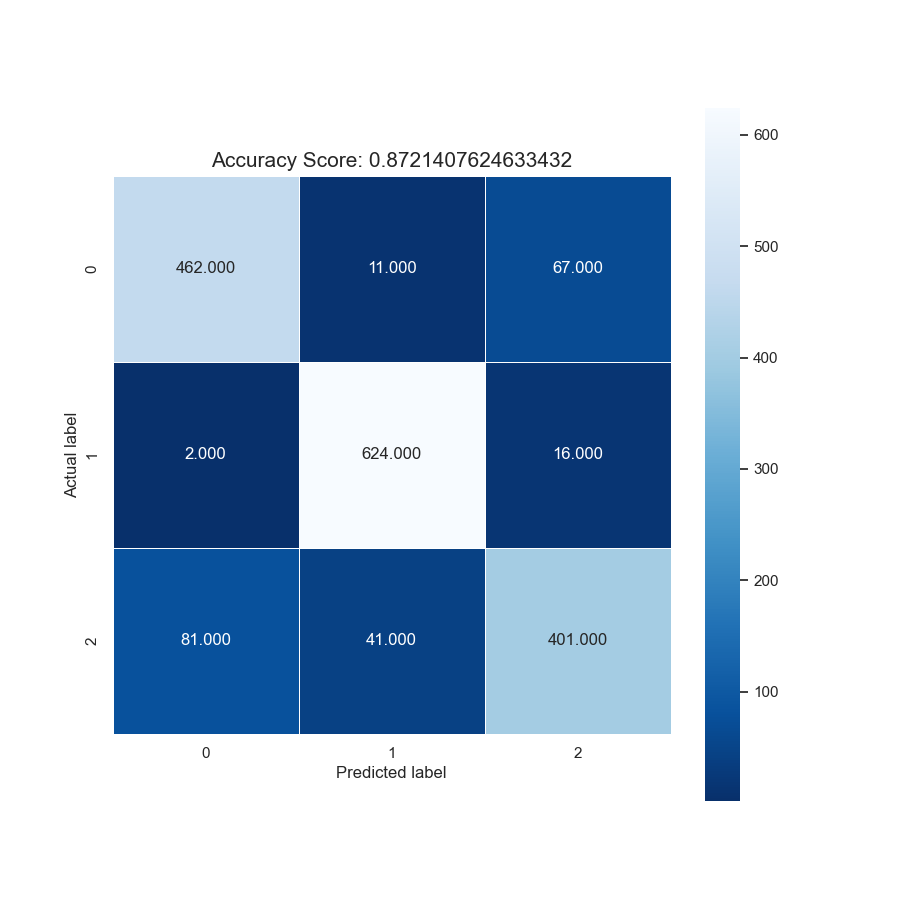

In [86]:
# Imprimir matriz de confusión más bonita

score = model_bow.score(X_te_bow,y_te)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [87]:
# Imprimir medidas de precisión y recall para cada clase.
# Debe notarse que por ser dos clases desbalanceadas,
# aunque el acierto dice 0.86, los valores de precisión y recall
# para la clase 0, son mucho más bajos: 0.73 y 0.64.

print(metrics.classification_report(y_te,prediciones_bow))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       540
           1       0.92      0.97      0.95       642
           3       0.83      0.77      0.80       523

    accuracy                           0.87      1705
   macro avg       0.87      0.86      0.86      1705
weighted avg       0.87      0.87      0.87      1705



[[462  11  67]
 [  2 622  18]
 [ 89  35 399]]


<IPython.core.display.Javascript object>


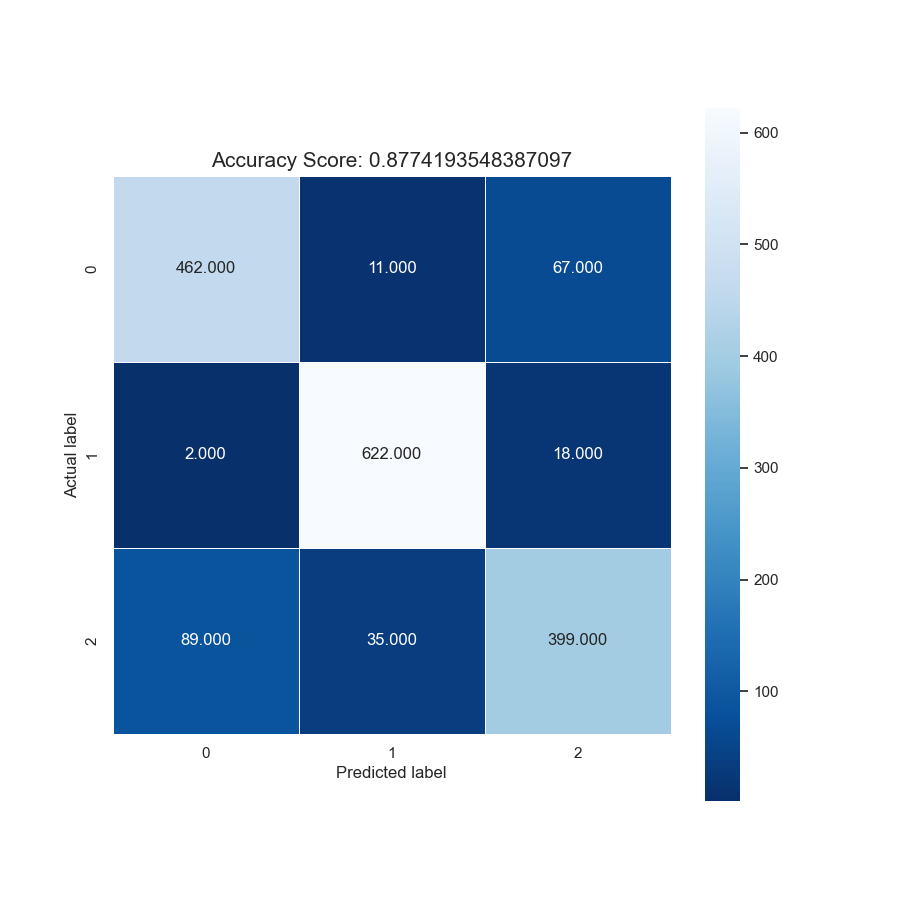

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       540
           1       0.93      0.97      0.95       642
           3       0.82      0.76      0.79       523

    accuracy                           0.87      1705
   macro avg       0.86      0.86      0.86      1705
weighted avg       0.87      0.87      0.87      1705



In [88]:
# Repetir informes para tf-idf

# Se obtienen las predicciones de clases para el conjunto de prueba
prediciones_tfidf = model_bow.predict(X_te_tfidf)

# Mostrar la matriz de confusión dadas las clases reales y las predichas.
cm = metrics.confusion_matrix(y_te, prediciones_tfidf)
print(cm)

# Imprimir matriz de confusión más bonita

score = model_tfidf.score(X_te_tfidf,y_te)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

# Imprimir medidas de precisión y recall para cada clase.
# Comparando con los resultados de bow, para la clase 0,
# la precisión es más baja y el recall es más alto.

print(metrics.classification_report(y_te,prediciones_tfidf))

#### Clasificador regresión logística - Texto_simple

In [89]:
# Los registros se representarán como bag-of-words (bow) de palabras.
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[1,1], lowercase=False) 

# Se transforman la columna 'Text_Cleaned' en un bow para conjunto de entrenamiento.
X_tr_bow = bow_transform.fit_transform(training_data['Texto_simple'])
print(len(bow_transform.vocabulary_))

# Se hace lo mismo para el conjunto de entrenamiento.
X_te_bow = bow_transform.transform(test_data['Texto_simple'])

8561


In [90]:
# Transformación usando tf-idf en lugar the conteo (bow).
tfidf_transform = text.TfidfTransformer(norm=None)

# El cálculo tfidf requiere los conteos ya realizados por bow.
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow)
X_te_tfidf = tfidf_transform.transform(X_te_bow)

In [91]:
# Clasificar usando bag-of-words
model_bow = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')

# Clasificar usando tf*idf
model_tfidf = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')

Test Score with bow features 0.8621700879765396
Test Score with tf-idf features 0.8604105571847507


In [92]:
# Matriz de confusión para bag-of-words

# Se obtienen las predicciones de clases para el conjunto de prueba
prediciones_bow = model_bow.predict(X_te_bow)

#<revisar repetidas>
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Mostrar la matriz de confusión dadas las clases reales y las predichas.
cm = metrics.confusion_matrix(y_te, prediciones_bow)
print(cm)

[[452   5  83]
 [  4 624  14]
 [ 86  43 394]]


<IPython.core.display.Javascript object>


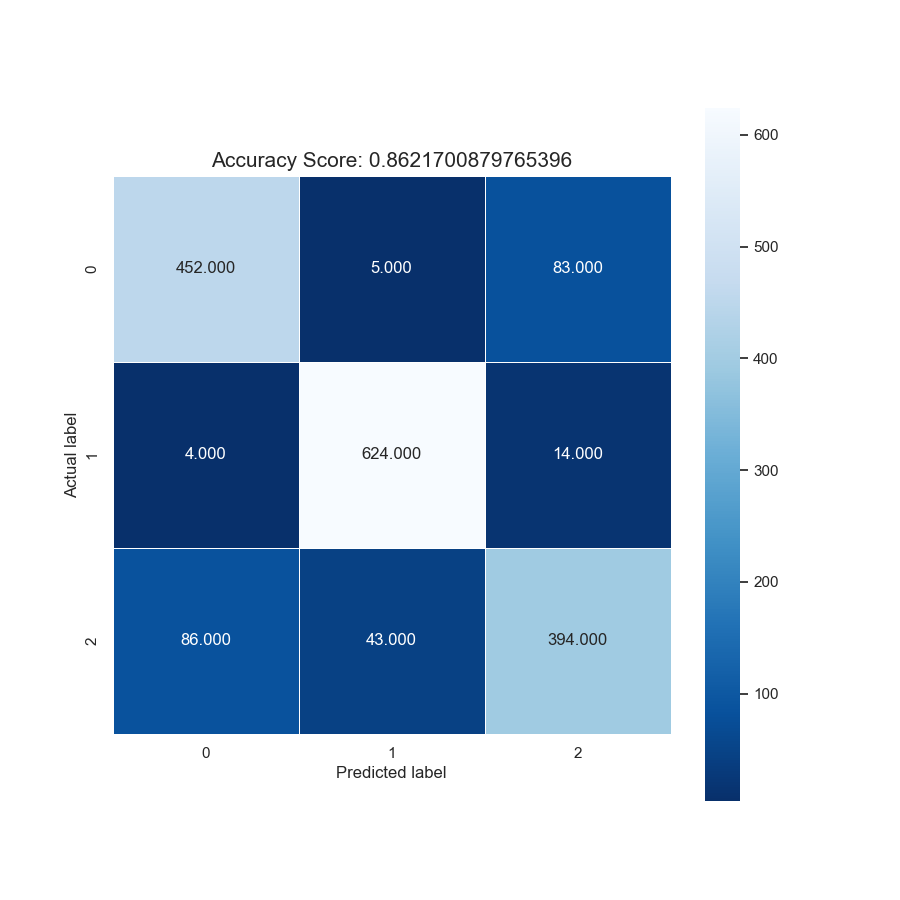

In [93]:
# Imprimir matriz de confusión más bonita

score = model_bow.score(X_te_bow,y_te)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [94]:
# Imprimir medidas de precisión y recall para cada clase.
# Debe notarse que por ser dos clases desbalanceadas,
# aunque el acierto dice 0.86, los valores de precisión y recall
# para la clase 0, son mucho más bajos: 0.73 y 0.64.

print(metrics.classification_report(y_te,prediciones_bow))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       540
           1       0.93      0.97      0.95       642
           3       0.80      0.75      0.78       523

    accuracy                           0.86      1705
   macro avg       0.85      0.85      0.85      1705
weighted avg       0.86      0.86      0.86      1705



[[453   5  82]
 [  4 622  16]
 [100  38 385]]


<IPython.core.display.Javascript object>


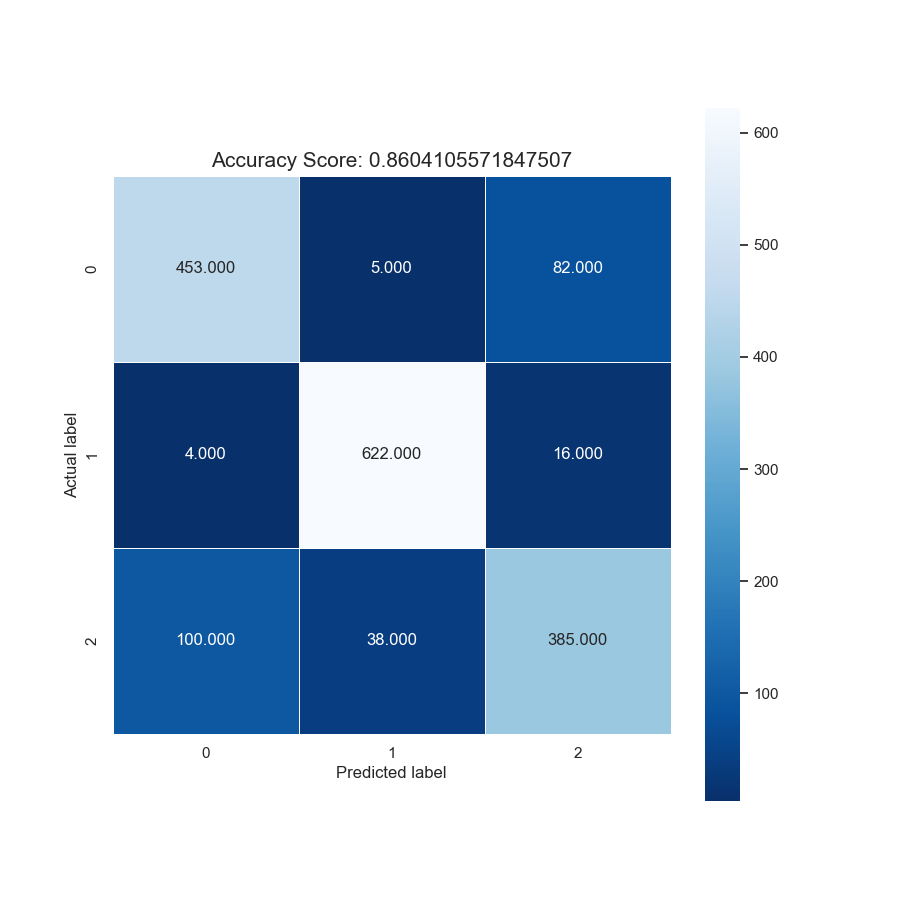

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       540
           1       0.94      0.97      0.95       642
           3       0.80      0.74      0.77       523

    accuracy                           0.86      1705
   macro avg       0.85      0.85      0.85      1705
weighted avg       0.85      0.86      0.85      1705



In [95]:
# Repetir informes para tf-idf

# Se obtienen las predicciones de clases para el conjunto de prueba
prediciones_tfidf = model_bow.predict(X_te_tfidf)

# Mostrar la matriz de confusión dadas las clases reales y las predichas.
cm = metrics.confusion_matrix(y_te, prediciones_tfidf)
print(cm)

# Imprimir matriz de confusión más bonita

score = model_tfidf.score(X_te_tfidf,y_te)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

# Imprimir medidas de precisión y recall para cada clase.
# Comparando con los resultados de bow, para la clase 0,
# la precisión es más baja y el recall es más alto.

print(metrics.classification_report(y_te,prediciones_tfidf))